In [168]:
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

In [3]:

# read tick data from http://www.kibot.com/support.aspx#data_format
cols = list(map(str.lower,['Date','Time','Price','Bid','Ask','Size']))

fp ='/Users/james/Dissertation/IVE_tickbidask.txt'
df = (pd.read_csv(fp, header=None)
      .rename(columns=dict(zip(range(len(cols)),cols)))
      .assign(dates=lambda df: (pd.to_datetime(df['date']+df['time'],
                                              format='%m/%d/%Y%H:%M:%S')))
      .assign(v=lambda df: df['size']) # volume
      .assign(dv=lambda df: df['price']*df['size']) # dollar volume
      .drop(['date','time'],axis=1)
      .set_index('dates')
      .drop_duplicates())
    

In [4]:
df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2021-06-23 15:59:59,146.15,146.15,146.18,322,322,47060.30
2021-06-23 15:59:59,146.15,146.15,146.18,300,300,43845.00
2021-06-23 16:00:00,146.15,146.15,146.21,14036,14036,2051361.40


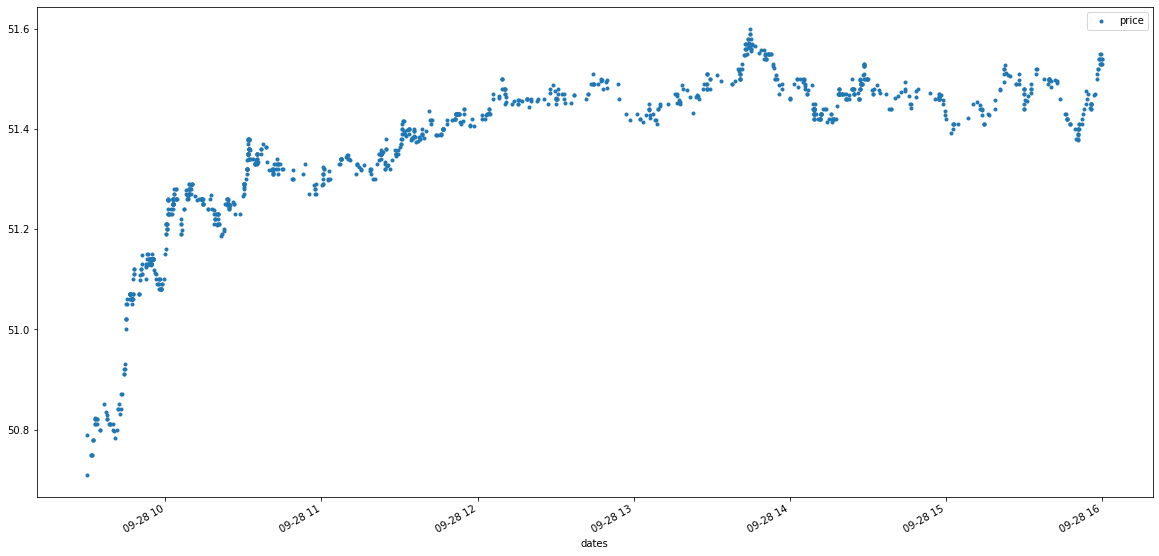

In [62]:
x = df['2009-09-28'].plot(style='.',y='price', figsize = (20,10))

### investigate data

In [5]:
def mad_outlier(y, thresh=3.):
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [6]:
mad = mad_outlier(df.price.values.reshape(-1,1))

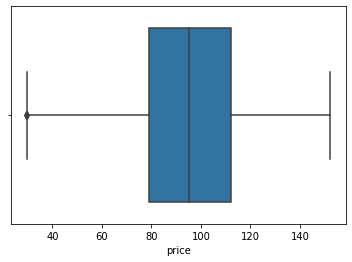

In [7]:
sns.boxplot(df.loc[~mad].price)

In [8]:
df = df.loc[~mad].drop_duplicates()

In [9]:
df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2021-06-23 15:59:59,146.15,146.15,146.18,322,322,47060.30
2021-06-23 15:59:59,146.15,146.15,146.18,300,300,43845.00
2021-06-23 16:00:00,146.15,146.15,146.21,14036,14036,2051361.40


In [99]:
def tickbars(df, number):
    #calculates the tick bars where "number" is the number of ticks in each bar.
    #The bars are calculated for each day seperately so no bars are calcualted overnight or over weekend.
    cumsize = [0]
    positions = []
    for i, day in enumerate(df.groupby(df.index.date)):
        n = day[1].shape[0]
        cumsize.append(int(n) + cumsize[i])
        positions = positions + [(1+x)*number + cumsize[i] for x in range(n//number)]
    return df.iloc[positions]

In [100]:
dftick = tickbars(df,100)

In [103]:
dftick

,price,bid,ask,size,v,dv,signs
dates,,,,,,,
2009-09-28 09:53:42,51.130,51.13,51.15,100,100,5113.000,-1.0
2009-09-28 10:02:52,51.250,51.24,51.26,4300,4300,220375.000,0.0
2009-09-28 10:23:06,51.250,51.23,51.25,500,500,25625.000,1.0
2009-09-28 10:38:44,51.365,51.34,51.36,100,100,5136.500,0.0
2009-09-28 11:24:29,51.330,51.32,51.33,653,653,33518.490,1.0
...,...,...,...,...,...,...,...
2021-06-23 10:08:27,146.610,146.59,146.61,200,200,29322.000,1.0
2021-06-23 11:09:18,146.609,146.59,146.61,135,135,19792.215,1.0
2021-06-23 13:05:33,146.516,146.51,146.53,200,200,29303.200,1.0


In [117]:
def volumebars(df, threshold):
    #calculates the volume bars where "threshold" is the cumulative volume at which a new bar is created. 
    #If there is leftover volume this carries over to the next bar.
    #The bars are calculated for each day seperately so no bars are calcualted overnight or over the weekend.
    cumsize = [0]
    positions = []
    for i, day in enumerate(df.groupby(df.index.date)):
        cumsum = 0
        idx= []
        for j, tick in enumerate(day[1]['v']):
            cumsum += tick
            if cumsum >= threshold:
                idx.append(j)
                cumsum -= threshold 
        positions = positions + [x+cumsize[i] for x in idx]
        n = day[1].shape[0]
        cumsize.append(int(n) + cumsize[i])

    return df.iloc[positions]

In [122]:
dfvolume = volumebars(df, 10000)

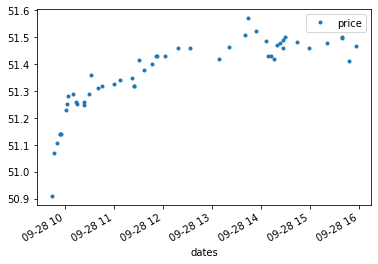

In [126]:
dfvolume['2009-09-28'].plot(y='price', style='.')

In [129]:
def dollarbars(df, threshold):
    #calculates the dollar bars where "threshold" is the cumulative dollar value at which a new bar is created. 
    #If there is leftover dollar value this carries over to the next bar.
    #The bars are calculated for each day seperately so no bars are calcualted overnight or over the weekend.
    cumsize = [0]
    positions = []
    for i, day in enumerate(df.groupby(df.index.date)):
        cumsum = 0
        idx= []
        for j, tick in enumerate(day[1]['dv']):
            cumsum += tick
            if cumsum >= threshold:
                idx.append(j)
                cumsum -= threshold 
        positions = positions + [x+cumsize[i] for x in idx]
        n = day[1].shape[0]
        cumsize.append(int(n) + cumsize[i])

    return df.iloc[positions]

In [132]:
dfdollar = dollarbars(df, 5000000)

In [133]:
dfdollar

,price,bid,ask,size,v,dv,signs
dates,,,,,,,
2009-09-28 10:09:05,51.2800,51.27,51.29,100,100,5128.00,-1.0
2009-09-28 11:07:26,51.3400,51.33,51.35,2000,2000,102680.00,0.0
2009-09-28 12:04:57,51.4300,51.43,51.45,100,100,5143.00,-1.0
2009-09-28 14:12:01,51.4300,51.43,51.45,500,500,25715.00,0.0
2009-09-28 15:35:01,51.5200,51.51,51.52,200,200,10304.00,0.0
...,...,...,...,...,...,...,...
2021-06-23 10:01:58,146.4700,146.47,146.48,1090,1090,159652.30,-1.0
2021-06-23 11:01:58,146.6800,146.68,146.69,800,800,117344.00,0.0
2021-06-23 13:30:06,146.6016,146.60,146.61,300,300,43980.48,-1.0


In [164]:
def tickimbalancebars(df, initT, warmup, expT, expB):
    #initT is the initial value for the threshold T
    #warmup is the number of ticks to use to use to calculate EWMA of the probability of buys/sells
    #expT is the exponential decay factor in calculating the EWMA of the expected T size 
    #expb is the exonential decay factor in calculating the EWMA of the probability of a buy tick
    df['signs'] = np.sign((df.price - df.price.shift(1)).replace(np.nan, 0))
    probB = 0
    cumsum = 0
    T = initT
    positions = []
    Tlength = 0
    indicator = 0 
    cumsize=[0]
    for j, day in enumerate(df.groupby(df.index.date)):
        
        samplingtimes = []
        for num, i in enumerate(day[1]['signs']):

            if i == 0:    
                probB = 0.5 * expB + probB * (1-expB)
            else:
                probB = (i==1) * expB + probB * (1-expB)

            if num > warmup:
                if indicator == 0:
                    probBpast = probB
                    indicator = 1
                cumsum += i
                Tlength += 1
                if abs(cumsum) >= T*abs(2*probBpast -1):
                    T = Tlength * expT + T * (1-expT)
                    cumsum = 0
                    samplingtimes.append(num)
                    Tlength = 0
                    probBpast = probB
        indicator = 0
        cumsum=0
        T=initT
        Tlength = 0
        positions = positions + [x+cumsize[j] for x in samplingtimes]
        cumsize.append(cumsize[j] + day[1].shape[0])
            
            
    return df.iloc[positions]

In [165]:
x= tickimbalancebars(df,20, 100, 0.05, 0.08)

In [166]:
x

,price,bid,ask,size,v,dv,signs
dates,,,,,,,
2009-09-28 10:01:05,51.2600,51.23,51.26,500,500,25630.0000,1.0
2009-09-28 10:31:24,51.3380,51.32,51.34,605,605,31059.4900,1.0
2009-09-28 11:30:52,51.4000,51.39,51.40,100,100,5140.0000,1.0
2009-09-28 15:14:51,51.4112,51.41,51.42,147,147,7557.4464,-1.0
2009-09-29 09:54:28,51.7872,51.78,51.81,966,966,50026.4352,1.0
...,...,...,...,...,...,...,...
2021-06-23 10:18:23,146.7512,146.74,146.76,151,151,22159.4312,1.0
2021-06-23 10:46:22,146.5580,146.54,146.56,453,453,66390.7740,-1.0
2021-06-23 11:09:45,146.5600,146.56,146.57,480,480,70348.8000,-1.0


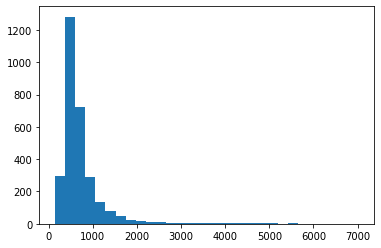

In [173]:
numofticksinday = []
for i, ticks in df.groupby(df.index.date):
    numofticksinday.append(ticks.shape[0])
plt.hist(numofticksinday, bins=30);

In [144]:
def volumeimbalancebars(df):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-144-db6f9eb8f001>, line 2)

In [ ]:
def dollarimbalancebars(df):
    